# Avito Demand Prediction Challenge - LightGBM Model

## Introduction
### The challenge
When selling used goods online, a combination of tiny, nuanced details in a product description can make a big difference in drumming up interest.

Avito, Russia’s largest classified advertisements website, is deeply familiar with this problem. Sellers on their platform sometimes feel frustrated with both too little demand (indicating something is wrong with the product or the product listing) or too much demand (indicating a hot item with a good description was underpriced).

In [their fourth Kaggle competition](https://kaggle.com/c/avito-demand-prediction), Avito is challenging participants to predict demand for an online advertisement based on its full description (title, description, images, etc.), its context (geographically where it was posted, similar ads already posted) and historical demand for similar ads in similar contexts. With this information, Avito can inform sellers on how to best optimize their listing and provide some indication of how much interest they should realistically expect to receive.

The description of the data files from the [data page](https://www.kaggle.com/c/avito-demand-prediction/data):

* train.csv - Train data.
* test.csv - Test data. Same schema as the train data, minus deal_probability.
* train_active.csv - Supplemental data from ads that were displayed during the same period as train.csv. Same schema as the train data, minus deal_probability.
* test_active.csv - Supplemental data from ads that were displayed during the same period as test.csv. Same schema as the train data, minus deal_probability.
* periods_train.csv - Supplemental data showing the dates when the ads from train_active.csv were activated and when they where displayed.
* periods_test.csv - Supplemental data showing the dates when the ads from test_active.csv were activated and when they where displayed. Same schema as periods_train.csv, except that the item ids map to an ad in test_active.csv.
* train_jpg.zip - Images from the ads in train.csv.
* test_jpg.zip - Images from the ads in test.csv.
* sample_submission.csv - A sample submission in the correct format.

### LightGBM model

In this notebook, we will train a [LightGBM](https://github.com/Microsoft/LightGBM) model to predict deal probabilities. LightGBM is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms. It is under the umbrella of the [DMTK](http://github.com/microsoft/dmtk) project of Microsoft.

We break this notebook down into 4 steps:

- [Step 1](#step1): Read in csv files
- [Step 2](#step2): Engineer features: 
    - [categorical features](#step2a)
    - [numerical features](#step2b)
    - [text](#step2c)
- [Step 3](#step3): Train and validate the model
- [Step 4](#step4): Predict deal probabilities

Then I'll end this notebook with [results and ideas for further improvement](#step5).

First, let's import some libraries.

In [1]:
import time
import gc
import random
import pickle

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix

from nltk.corpus import stopwords 

import lightgbm as lgb

import matplotlib.pyplot as plt

import string

from utils import *

%matplotlib inline

/home/trang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<a id='step1'></a>
## Load data

We will load the training, testing and aggregated data.

In [2]:
train = pd.read_csv("./csv/train.csv", index_col = "item_id", parse_dates = ["activation_date"])
test = pd.read_csv("./csv/test.csv", index_col = "item_id", parse_dates = ["activation_date"])
train.head()

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
item_id,,,,,,,,,,,,,,,,,
b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [3]:
# Load and merge aggregated features into training and testing dataframes
af = pd.read_csv("csv/aggregated_features.csv", index_col=False)
train = train.merge(af, on="user_id", how="left")
test = test.merge(af, on="user_id", how="left")

agg_cols = list(af.columns)[1:]

del af
gc.collect()

54

We will combine training and testing data so that it's convenient when engineering features, etc.

In [4]:
# Make a copy of the target column before merging
y_train = train.deal_probability.copy()
train.drop("deal_probability", axis=1, inplace=True)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Store the number of rows for each dataframe
n_train_rows = train.shape[0]
n_test_rows = test.shape[0]

# Combine traing and testing data
df = pd.concat([train, test], axis=0)

# Remove unused features
df.drop(["activation_date", "image"],axis=1,inplace=True)
print("All data shape:", df.shape)

del train, test
gc.collect()

Train shape: (1503424, 19)
Test shape: (508438, 19)
All data shape: (2011862, 17)


21

<a id='step2'></a>
## Engineer features
<a id='step2a'></a>
### Categorical features

We will first engineer categorical features: filling NA values and encoding the features.

In [5]:
categorical = ["user_id", "region","city", "parent_category_name", "category_name", "user_type", "image_top_1", "param_1", "param_2", "param_3"]
# Fill NA values for image_top_1 with -1
df["image_top_1"].fillna(-1, inplace=True)

# Encode the features using LabelEncoder since we are using a decision tree model.
# If we use other models, we should consider One-Hot-Encoding + PCA
# https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor
label_encoder = preprocessing.LabelEncoder()
for col in categorical:
    df[col].fillna("unknown")
    df[col] = label_encoder.fit_transform(df[col].astype(str))

<a id='step2b'></a>
### Numerical features

We will move on to numerical features. 
- For prices, we will fill NA prices with the median value. Then we will take the natural logarithm of price for reasons described [here](https://stats.stackexchange.com/questions/298/in-linear-regression-when-is-it-appropriate-to-use-the-log-of-an-independent-va).  
- For aggregated features, we will simply fill NA values with -1

In [6]:
df["price"].fillna(df.price.median(), inplace=True)
df["price"] = np.log1p(df["price"])
for col in agg_cols:
    df[col].fillna(-1, inplace=True)

<a id='step2c'></a>
### Text features

Now we will engineer text features. In the cell below, we will create new text features by counting the number of words, characters, digits, etc.

In [7]:
start_text_feat = time.time()

text_feats = ["description", "title"]
df["desc_punc"] = df["description"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

for col in text_feats:
    # Change text to lowercase and lemmatize text
    df[col] = df[col].apply(lambda x: pre_process(x))
    df[col] = df[col].fillna("unknown")
    df[col + "_num_words"] = df[col].apply(lambda x: len(x.split()))
    df[col + "_num_unique_words"] = df[col].apply(lambda x: len(set(w for w in x.split())))
    df[col + "_words_vs_unique"] = df[col + "_num_unique_words"] / df[col + "_num_words"] * 100 
    df[col + "_num_chars"] = df[col].apply(lambda x: len(x))
    df[col + "_num_alphabets"] = df[col].apply(lambda x: (x.count(r"[a-zA-Z]")))
    df[col + "_num_alphanumeric"] = df[col].apply(lambda x: (x.count(r"[A-Za-z0-9]")))
    df[col + "_num_digits"] = df[col].apply(lambda x: (x.count("[0-9]")))
    
df["title_desc_len_ratio"] = df["title_num_chars"] / df["description_num_chars"] * 100
df["desc_punc_ratio"] = df["desc_punc"] / df["description_num_chars"] *100

print("Creating new text features took: %0.2f minutes"%((time.time() - start_text_feat) / 60))

Creating new text features took: 45.33 minutes


Next, we will vectorize text.

In [9]:
# Helper function to return a column from a dataframe
def get_col(col_name): 
    return lambda x: x[col_name]

russian_stop = set(stopwords.words("russian"))
tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": "word",
    "token_pattern": r"\w{1,}",
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": "l2",
    "smooth_idf":False
}

vectorizer = FeatureUnion([
        ("description", TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=15000,
            **tfidf_para,
            preprocessor=get_col("description"))),
        ("title", CountVectorizer(
            ngram_range=(1, 2),
            stop_words = russian_stop,
            preprocessor=get_col("title")))
    ])
    
start_vect=time.time()

vectorizer.fit(df.to_dict("records"))
vectorized_features = vectorizer.transform(df.to_dict("records"))

# Store the names of vectorized text features in a list for use later with LightGBM
feature_names = vectorizer.get_feature_names()

print("Vectorization runtime: %0.2f minutes"%((time.time() - start_vect) / 60))

Vectorization runtime: 7.26 minutes


Let's print out some information about `vectorized_features`.

In [16]:
print(type(vectorized_features))
print(vectorized_features[:5])

<class 'scipy.sparse.csr.csr_matrix'>
  (0, 6041)	0.4543893833878289
  (0, 7068)	0.25929010686776116
  (0, 7081)	0.2746891748346552
  (0, 7307)	0.22512829318931382
  (0, 9905)	0.26460858705946444
  (0, 9910)	0.3905090765801592
  (0, 12056)	0.2866256844030417
  (0, 12455)	0.3570984005206791
  (0, 14250)	0.1846703379952123
  (0, 14277)	0.3658829184219402
  (0, 709955)	1.0
  (0, 709956)	1.0
  (0, 709963)	1.0
  (0, 710044)	1.0
  (0, 1079815)	1.0
  (1, 2957)	0.5775736475334812
  (1, 3261)	0.553098801207857
  (1, 8510)	0.39416011875467694
  (1, 12917)	0.45291080640739895
  (1, 883789)	1.0
  (1, 1097960)	1.0
  (1, 1098177)	1.0
  (2, 2131)	0.40594257312454046
  (2, 2249)	0.2500699308745464
  (2, 4712)	0.2697888109891143
  :	:
  (2, 7826)	0.3238878711826573
  (2, 10946)	0.18077023298841607
  (2, 12313)	0.36779397374107975
  (2, 12499)	0.0958742990789805
  (2, 13118)	0.29891956069067105
  (2, 13364)	0.15083932622521384
  (2, 14175)	0.12413745049681915
  (2, 14207)	0.14984499153463327
  (2, 17221

Before moving on, let's save `feature_names` and `df` that includes engineered features. This will save time in case we need to stop this notebook now, and resume it later. When we resume, we can just load these saved items without running the above code.

In [17]:
# Drop text columns
df.drop(text_feats, axis=1, inplace=True)

# Save df and feature_names so that we can quickly load them another time
df.to_csv("csv/df_engineered_feats.csv")

PICKLED_FEATS = "vectorized_feats.dat"

with open(PICKLED_FEATS, "wb") as f:
    pickle.dump(feature_names, f)
# Uncomment below to load the saved features
#with open(PICKLED_FEATS, "rb") as f:
 #   feature_names = pickle.load(f)

Now that we have finished feature engineering, we will stack dense features and sparse vectorized text features together. Before stacking them, we have to convert dense features to sparse matrices using `scipy.sparse.csr_matrix`.

In [18]:
# Convert dense features to sparse matrices and stack them with sparse vectorized text features
X = hstack([csr_matrix(df[:n_train_rows]), vectorized_features[0:n_train_rows]])
X_test = hstack([csr_matrix(df[n_train_rows:]), vectorized_features[n_train_rows:]])

# Update feature_names with the column names of df
feature_names = df.columns.tolist() + feature_names
print("Number of featues: ", len(feature_names))

del df, vectorizer, vectorized_features
gc.collect()

Number of featues:  1242383


<a id='step3'></a>
## Train and validate a LightGBM model

Now we are ready to go! In this section, we will train a LightGBM model. I tuned these two parameters manually, trying the following values:
- `learning_rate`: 0.1, 0.01, 0.015, 0.02
- `num_leaves`: 30, 60, 100, 200


I did try to use GridSearchCV but got out of memory error. Here's the final list of parameters:

In [19]:
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 200,
    'max_depth': 15,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.6,
    'verbosity' : -1
}

In [32]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y_train, test_size=0.10, random_state=2018)
    
# LightGBM dataset formatting 
lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=feature_names,
                categorical_feature = categorical)
lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=feature_names,
                categorical_feature = categorical)
del X, X_train
gc.collect()

(1503424, 1242383)
(1503424,)


1131

In [35]:
# Train and validate the model
lgb_clf = lgb.train(
    params,
    lgtrain,
    num_boost_round=20000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=["train", "valid"],
    early_stopping_rounds=500,
    verbose_eval=500
)
print("RMSE of the validation set:", np.sqrt(mean_squared_error(y_valid, lgb_clf.predict(X_valid))))

/home/trang/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/trang/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	train's rmse: 0.214333	valid's rmse: 0.221391
[1000]	train's rmse: 0.209612	valid's rmse: 0.220006
[1500]	train's rmse: 0.206841	valid's rmse: 0.219424
[2000]	train's rmse: 0.204628	valid's rmse: 0.219061
[2500]	train's rmse: 0.202761	valid's rmse: 0.218807
[3000]	train's rmse: 0.201106	valid's rmse: 0.218608
[3500]	train's rmse: 0.19961	valid's rmse: 0.218445
[4000]	train's rmse: 0.198259	valid's rmse: 0.218321
[4500]	train's rmse: 0.197017	valid's rmse: 0.218214
[5000]	train's rmse: 0.19584	valid's rmse: 0.218122
[5500]	train's rmse: 0.194811	valid's rmse: 0.218043
[6000]	train's rmse: 0.193779	valid's rmse: 0.217982
[6500]	train's rmse: 0.192784	valid's rmse: 0.217922
[7000]	train's rmse: 0.191848	valid's rmse: 0.21787
[7500]	train's rmse: 0.19092	valid's rmse: 0.217818
[8000]	train's rmse: 0.189971	valid's rmse: 0.217766
[8500]	train's rmse: 0.189098	valid's rmse: 0.217732
[9000]	train's rmse: 0.188262	valid's rms

<a id='step4'></a>
## Predict deal probabilities

Text(0.5,1,'Light GBM Feature Importance')

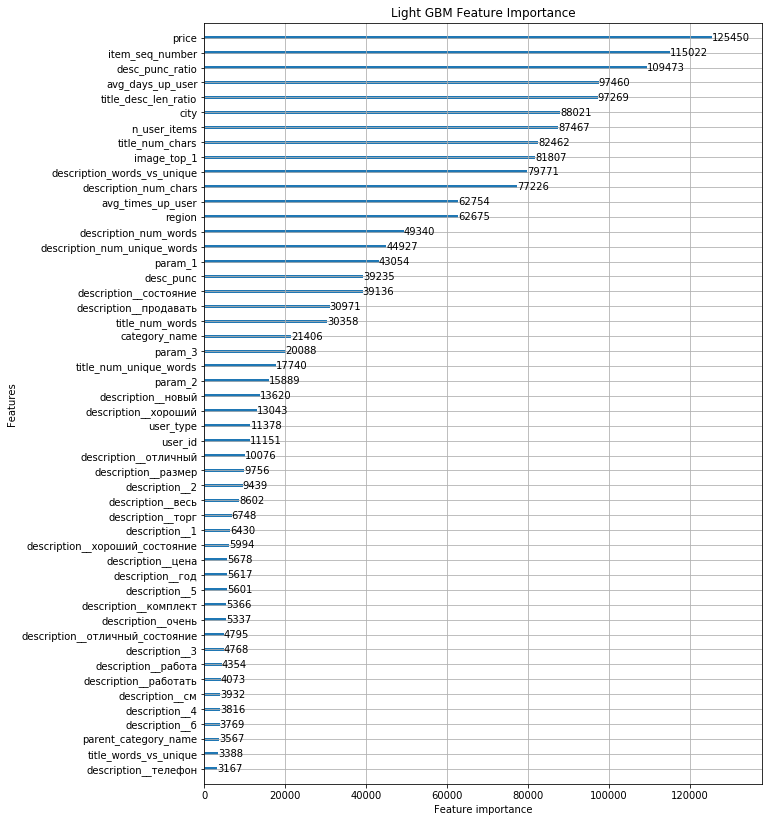

In [36]:
fig, ax = plt.subplots(figsize=(10, 14))
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")

Finally we are ready to generate predictions and submit the results on Kaggle! 

In [45]:
submission = pd.read_csv('./csv/sample_submission.csv')
submission['deal_probability'] = np.clip(lgb_clf.predict(X_test), 0, 1)
submission.to_csv('submission_lightgbm.csv', index=False)

/home/trang/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


<a id='step5'></a>
## Results and Further Improvement

With this model, I got an RSME of 0.2220 on the public leader board and 0.2255 on the private one. The 1st prize winner's scores are 0.2105 and 0.2150 on respective boards

In my opinions, there are opportunities for improvement:
- Images: 
  - Extracting image features, instead of classification scores
  - Extracting image quality features: dullness, brightness, blurriness, etc.
- Text: Using a pre-trained word embedding
- Using PCA to reduce dimensionality 
- Modeling: 
  - Trying a different model, such as a neural network
  - Blending different models
- Validation: Using k-fold validation. I wrote the following function to get a cross-validation score but wasn't able to do k-fold validation due to memory error

```python
def cv_estimate(X_train, y_train, n_splits=5):
    """Return the validation score for K-Fold validation."""
    cv = KFold(n_splits=n_splits)
    val_scores = 0.0
    for train, test in cv.split(X_train, y_train):
        lgtrain = lgb.Dataset(X_train[train], y_train[train])
        clf = lgb.train(params, lgtrain, num_boost_round=16000, verbose_eval=500)
        y_pred = clf.predict(X_train[test])
        val_scores += np.sqrt(mean_squared_error(y_pred, y_train[test]))
    val_scores /= n_splits
    return val_scores
cv_score = cv_estimate(X, y_train, 5)
print(cv_score)
```